# Project 1: Logistic Regression
## This Project gives extra points for the final grade

## **Due 27.11.2025, 16:00**

## Overview

### **Submit your project solution as a group of 2-4 people.**

In this project, you will train a **Logistic Regression** model on a non-linear dataset. The following steps serve as a guide:

### Tasks

1. **Feature Engineering**
   - Since Logistic Regression is a linear classifier, you need to perform feature engineering to make the data linearly separable
   - Consider preprocessing original features
   - Figure out what extra features you should add to the data

2. **Implement Training Loop**
   - Implement the training loop for your Logistic Regression model using **Gradient Descent**
   - Use **BCE Loss** (Binary Cross-Entropy)
   - Incorporate a **regularization** technique to prevent overfitting

3. **Hyperparameter Tuning**
   - Train your model and find good hyperparameters using the **validation set**

4. **Visualization**
   - Visualize the **loss and accuracy curves** of the training process

5. **Testing & Evaluation**
   - Test your trained model on the given **test set**
   - Output the final accuracy rate

### **For full points you need to atleast achieve 73% accuracy on the testing set**

### **NOTE**: 
#### You are not allowed to use sklearn, pytorch or similar Deep Learning frameworks. Numpy is allowed.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA_PATH = "dataset.csv"
df = pd.read_csv(DATA_PATH)
X = df[["x1", "x2"]].values.astype(float)
y = df["y"].values.astype(int)
print(f"Dataset shape: {X.shape}")
print(f"Classes: {np.unique(y)}")
print(f"\nFirst 5 samples:")
print(df.head())

train_split = int(len(X) * 0.7)      
val_split = int(len(X) * 0.85)       

x_train = X[:train_split]              
x_val = X[train_split:val_split]    
x_test = X[val_split:]  
y_train = y[:train_split]              
y_val = y[train_split:val_split]    
y_test = y[val_split:]
print(f"\nTrain set: {x_train.shape[0]} samples")
print(f"Validation set: {x_val.shape[0]} samples")
print(f"Test set: {x_test.shape[0]} samples")


Dataset shape: (1000, 2)
Classes: [0 1]

First 5 samples:
          x1        x2  y
0   9.492170  0.272589  0
1  16.829156 -0.787517  0
2   0.175471  0.412100  1
3  80.509510 -0.688343  1
4  68.193111  1.447592  0

Train set: 700 samples
Validation set: 150 samples
Test set: 150 samples


In [2]:
def visualize(X, y, title="Data Visualization"):
    cls0 = y == 0
    cls1 = y == 1
    plt.figure()
    plt.scatter(X[cls0, 0], X[cls0, 1], label="y=0", alpha=0.7)
    plt.scatter(X[cls1, 0], X[cls1, 1], label="y=1", alpha=0.7)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

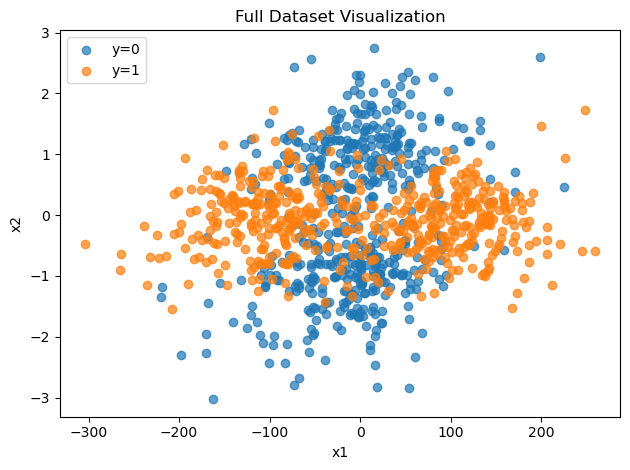

In [3]:
visualize(X, y, title="Full Dataset Visualization")

**(1) Feature Engineering: 2 Points**

Since logistic regression is a linear classifier, one can not expect to perform very well on data that is not linearly seperable. 

Try to figure out how to transform the data, e.g preprocessing original features and adding new features, such that the data becomes linearly seperable.

In [4]:
# TODO: (1) Feature Engineering to prepare data for logistic regression
def add_features(X):
    """
    Input X: (N,2) -> output: (N, D) expanded features.
    Features included:
      - original x1, x2
      - polynomial: x1^2, x2^2, x1*x2
      - radius r = x1^2 + x2^2  (useful for circular patterns)
      - optionally r^2 to increase flexibility
    """
    x1 = X[:, 0:1]
    x2 = X[:, 1:2]
    x1_sq = x1 ** 2
    x2_sq = x2 ** 2
    x1x2 = x1 * x2
    r = x1_sq + x2_sq
    r_sq = r ** 2
    # Stack features horizontally
    X_feat = np.hstack([x1, x2, x1_sq, x2_sq, x1x2, r, r_sq])
    return X_feat

def standardize(X_train, X_val, X_test):
    """
    Standardize features using training set mean and std.
    Returns standardized arrays and (mean, std).
    """
    mu = X_train.mean(axis=0, keepdims=True)
    sigma = X_train.std(axis=0, keepdims=True)
    # avoid division by zero
    sigma[sigma == 0] = 1.0
    X_train_s = (X_train - mu) / sigma
    X_val_s = (X_val - mu) / sigma
    X_test_s = (X_test - mu) / sigma
    return X_train_s, X_val_s, X_test_s, mu, sigma

# Prepare features for train/val/test using your existing splits: x_train,x_val,x_test
Xtr_fe = add_features(x_train)
Xval_fe = add_features(x_val)
Xtest_fe = add_features(x_test)

Xtr_s, Xval_s, Xtest_s, mu_feat, sigma_feat = standardize(Xtr_fe, Xval_fe, Xtest_fe)

# Convert labels to column vectors
y_tr = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print("Original X_train shape:", x_train.shape)
print("Feature-engineered X_train shape:", Xtr_fe.shape)
print("Standardized X_train shape:", Xtr_s.shape)

print("\nTraining labels shape:", y_tr.shape)
print("Validation labels shape:", y_val.shape)
print("Test labels shape:", y_test.shape)

# Print first row before and after feature engineering + standardization
print("\nFirst original sample:", x_train[0])
print("First engineered sample:", Xtr_fe[0])
print("First standardized sample:", Xtr_s[0])

Original X_train shape: (700, 2)
Feature-engineered X_train shape: (700, 7)
Standardized X_train shape: (700, 7)

Training labels shape: (700, 1)
Validation labels shape: (150, 1)
Test labels shape: (150, 1)

First original sample: [9.49216964 0.27258876]
First engineered sample: [9.49216964e+00 2.72588757e-01 9.01012845e+01 7.43046306e-02
 2.58745873e+00 9.01755891e+01 8.13163688e+03]
First standardized sample: [ 0.12864608  0.3289773  -0.78164467 -0.67326137  0.01296009 -0.78173247
 -0.41641853]


**(2) Training Logic: 2 Points**

Implement the training logic by finding the best model parameters for logistic regression. Since we have only 2 classes, BCE Loss is a proper loss function. 

Consider implementing regularization to avoid overfitting.

The training loop should take the training set (- and validation set for hyperparameter tuning later), aswell as the hyperparameters, initialize weights and do gradient descent. 

You should track the losses and accuracies throughout the epochs for later visualization.

In [5]:
# TODO: (2) implement training loop with BCE Loss
# hint: consider regularization to avoid overfitting
# you should return the loss and accuracy values per epoch for later visualization


# These following functions are only meant to be a guideline, you can implement your own versions
def sigmoid(z):
    z = np.clip(z, -500, 500)  # numerical stability
    return 1 / (1 + np.exp(-z))

def predict(X, W, b):
    return sigmoid(X @ W + b)

def bce_loss(W, b, X, y, lam=0.0):
    N = X.shape[0]
    p = predict(X, W, b)
    eps = 1e-12
    p = np.clip(p, eps, 1 - eps)

    # BCE
    loss = -(y * np.log(p) + (1 - y) * np.log(1 - p)).mean()

    # L2 regularization (on weights only)
    loss += (lam / (2 * N)) * np.sum(W**2)

    return loss

def grad_bce_with_l2(W, b, X, y, lam=0.0):
    N = X.shape[0]
    p = predict(X, W, b)
    error = p - y  # (N,1)

    dW = (X.T @ error) / N + (lam / N) * W
    db = np.sum(error) / N

    return dW, db

def accuracy(y, p):
    return (y.flatten() == (p.flatten() >= 0.5)).mean()

def train_model(X_tr, y_tr, X_val, y_val, lr=0.1, lam=0.0, epochs=100):
    N, D = X_tr.shape

    # Initialize weights
    rng = np.random.default_rng(42)
    W = rng.normal(scale=0.01, size=(D,1))
    b = 0.0

    # History lists
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        # Compute gradients
        dW, db = grad_bce_with_l2(W, b, X_tr, y_tr, lam)

        # Gradient descent update
        W -= lr * dW
        b -= lr * db

        # Record losses
        train_losses.append(bce_loss(W, b, X_tr, y_tr, lam))
        val_losses.append(bce_loss(W, b, X_val, y_val, lam))

        # Record accuracies
        train_accs.append(accuracy(y_tr, predict(X_tr, W, b)))
        val_accs.append(accuracy(y_val, predict(X_val, W, b)))

    return W, b, train_losses, val_losses, train_accs, val_accs

**(3) Hyperparameter tuning: 0.5 Points**

Your logistic regression model has hyperparameters, e.g. learning rate/regularization lambda, and since there are no  best hyperparameters in general, one has to find them by grid searching through them for the specific model.

Implement the grid search function by going through all possible defined parameters, train the model and evaluate on validation set. 

Save the best hyperparameters and return them.

In [6]:
# TODO: (3) implement hyperparameter tuning

# Fill in learning rates and lambda values to search
lr_list = [0.1, 0.05, 0.01, 0.005, 0.001]
lambda_list = [0.0, 0.001, 0.01, 0.1, 0.5, 1.0, 3.0]

def grid_search(X_tr, y_tr, X_val, y_val, lr_list, lambda_list, epochs=100):
    best_lr = None
    best_lambda = None
    best_val_acc = -np.inf

    for lr in lr_list:
        for lam in lambda_list:

            # Train model with chosen hyperparameters
            W, b, train_losses, val_losses, train_accs, val_accs = train_model(
                X_tr, y_tr, X_val, y_val,
                lr=lr, lam=lam, epochs=epochs
            )

            # Validation accuracy at last epoch
            final_val_acc = val_accs[-1]

            print(f"lr={lr}, lambda={lam} -> val_acc={final_val_acc:.4f}")

            # Update best hyperparameters
            if final_val_acc > best_val_acc:
                best_val_acc = final_val_acc
                best_lr = lr
                best_lambda = lam

    print("\nBest hyperparameters found:")
    print(f"  lr = {best_lr}")
    print(f"  lambda = {best_lambda}")
    print(f"  best validation accuracy = {best_val_acc:.4f}")

    return best_lr, best_lambda

**(4) Training and (5) Testing: 0.5 Points**

- Use grid search to find the best hyperparameters
- train your model with found hyperparameters
- visualize loss and accuracy curves
- test your model on the testing set

In [7]:
# TODO: (4) use grid search to find the best hyperparameters

best_lr, best_lambda = best_lr, best_lambda = grid_search(
    Xtr_s, y_tr,
    Xval_s, y_val,
    lr_list, lambda_list,
    epochs=500
    )

print(f"Best hyperparameters: lr={best_lr}, lam={best_lambda}")

# Train final model using found hyperparameters
W_best, b_best, train_losses, val_losses, train_accs, val_accs = train_model(
    Xtr_s, y_tr,
    Xval_s, y_val,
    lr=best_lr,
    lam=best_lambda,
    epochs=800
)

lr=0.1, lambda=0.0 -> val_acc=0.7933
lr=0.1, lambda=0.001 -> val_acc=0.7933
lr=0.1, lambda=0.01 -> val_acc=0.7933
lr=0.1, lambda=0.1 -> val_acc=0.7933
lr=0.1, lambda=0.5 -> val_acc=0.7933
lr=0.1, lambda=1.0 -> val_acc=0.7933
lr=0.1, lambda=3.0 -> val_acc=0.7933
lr=0.05, lambda=0.0 -> val_acc=0.7800
lr=0.05, lambda=0.001 -> val_acc=0.7800
lr=0.05, lambda=0.01 -> val_acc=0.7800
lr=0.05, lambda=0.1 -> val_acc=0.7800
lr=0.05, lambda=0.5 -> val_acc=0.7800
lr=0.05, lambda=1.0 -> val_acc=0.7800
lr=0.05, lambda=3.0 -> val_acc=0.7800
lr=0.01, lambda=0.0 -> val_acc=0.7667
lr=0.01, lambda=0.001 -> val_acc=0.7667
lr=0.01, lambda=0.01 -> val_acc=0.7667
lr=0.01, lambda=0.1 -> val_acc=0.7667
lr=0.01, lambda=0.5 -> val_acc=0.7667
lr=0.01, lambda=1.0 -> val_acc=0.7667
lr=0.01, lambda=3.0 -> val_acc=0.7667
lr=0.005, lambda=0.0 -> val_acc=0.7600
lr=0.005, lambda=0.001 -> val_acc=0.7600
lr=0.005, lambda=0.01 -> val_acc=0.7600
lr=0.005, lambda=0.1 -> val_acc=0.7600
lr=0.005, lambda=0.5 -> val_acc=0.7600
lr

In [8]:
# TODO: train your model with found hyperparameters
W_best, b_best, train_losses, val_losses, train_accs, val_accs = train_model(
    Xtr_s, y_tr,
    Xval_s, y_val,
    lr=best_lr,
    lam=best_lambda,
    epochs=800
)

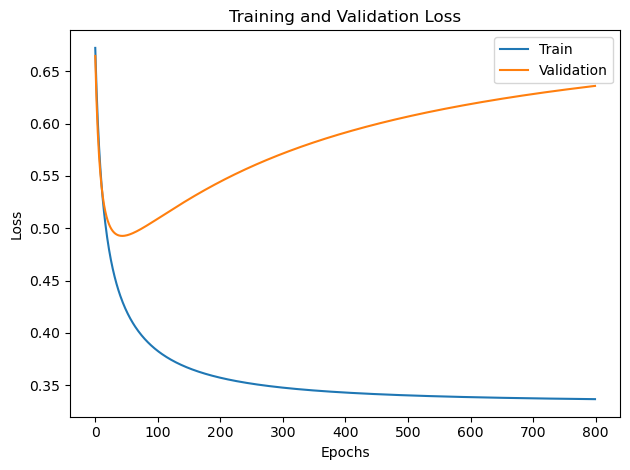

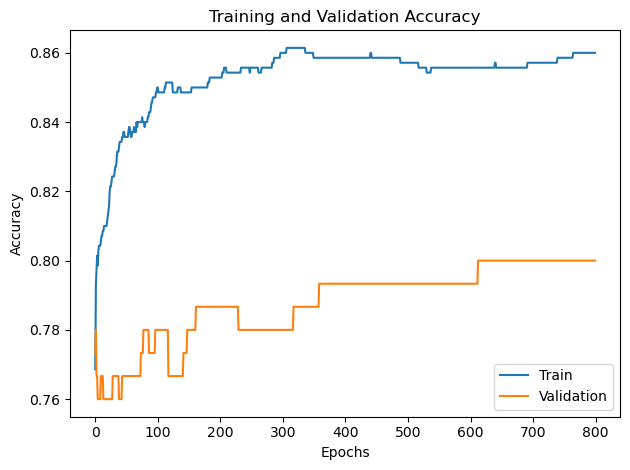

In [9]:
# visualize loss and accuracy curves
def plot_curves(train_values, val_values, ylabel, title):
    plt.figure()
    plt.plot(train_values, label="Train")
    plt.plot(val_values, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_curves(train_losses, val_losses, ylabel="Loss", title="Training and Validation Loss")
plot_curves(train_accs, val_accs, ylabel="Accuracy", title="Training and Validation Accuracy")

In [10]:
# TODO: (5) test your model on the test set
# Predict probabilities on test set
p_test = predict(Xtest_s, W_best, b_best)

# Compute test accuracy
test_acc = accuracy(y_test, p_test)

print(f"Final Test Accuracy: {test_acc:.4f}")

Final Test Accuracy: 0.7667
